# Radar Classification

## A Radar Classification Basics

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from cvxpy.atoms.affine.wraps import psd_wrap
from read_data import *
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%       MGT - 418         %%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%      Convex Optimization - Project 2          %%%%%%%%%%%%%%
#%%%%%%%%%%%%%%             2021-2022 Fall                    %%%%%%%%%%%%%%
#%%%%%%%%%%%%%%      Learning the Kernel Function             %%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

### (a) Read & Split data

**(5 points)** Read the data file ionosphere.data into memory by using the scriptsreaddata.pyorreaddata.m.Use the code skeletonsmain.ipnyb or main.m to randomly select 80% of the data for training.

In [2]:
data, labels = prepare_ionosphere_dataset()

In [3]:
import contextlib


#%% split train and test dataset
@contextlib.contextmanager
def temp_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)


def train_test_split(data, labels, train_size=0.8, random_seed=0):
    with temp_seed(random_seed):
        indices = np.random.permutation(data.shape[0])
        train_num = round(np.shape(data)[0] * train_size)
        train_idx, test_idx = indices[:train_num], indices[train_num:]
        # data_train, data_test, labels_train, labels_test
        return (
            data[train_idx, :],
            data[test_idx, :],
            labels[train_idx],
            labels[test_idx],
        )

In [4]:
for i in range(3):
    print("#{}".format(i))
    # data_train, data_test, labels_train, labels_test
    x_tr, x_te, y_tr, y_te  = train_test_split(data, labels, train_size=0.8, random_seed=i)
    print("Last training sample in x_tr:\n", x_tr[-1,:])
    print("Train : Test = {} : {}".format(y_tr.shape[0], y_te.shape[0]))

#0
Last training sample in x_tr:
 [1.0 0.95559 -0.00155 0.86421 -0.13244 0.94982 -0.00461 0.82809 -0.51171
 0.92441 0.10368 1.0 -0.14247 0.99264 -0.02542 0.95853 -0.15518 0.84013
 0.61739 1.0 -0.16321 0.87492 -0.08495 0.85741 -0.01664 0.84132 -0.01769
 0.82427 -0.01867 0.80634 -0.01957 0.78761 -0.02039]
Train : Test = 281 : 70
#1
Last training sample in x_tr:
 [1.0 1.0 0.0507 1.0 0.10827 1.0 0.19498 1.0 0.28453 1.0 0.34826 1.0
 0.38261 0.94575 0.42881 0.89126 0.50391 0.75906 0.58801 0.80644 0.59962
 0.79578 0.62758 0.66643 0.63942 0.59417 0.69435 0.49538 0.72684 0.47027
 0.71689 0.33381 0.75243]
Train : Test = 281 : 70
#2
Last training sample in x_tr:
 [1.0 0.73523 -0.38293 0.80151 0.10278 0.78826 0.15266 0.5558 0.05252 1.0
 0.21225 0.71947 0.28954 0.68798 0.32925 0.49672 0.17287 0.64333 -0.02845
 0.57399 0.42528 0.5312 0.44872 0.9453 0.57549 0.44174 0.482 0.12473 1.0
 0.3507 0.49721 0.30588 0.49831]
Train : Test = 281 : 70


### (b) Define kernel function & Solve QCQP

**(15 points)** Define polynomial, Gaussian, and linear kernel function, and construct the kernel matrices $\hat{K}^l,\ l = 1,2,3$, for all training samples
Solve the QCQP in (5) for $\rho = 2$, $p = 2$, $\sigma = 2$ and $c = \sum_{l=1}^3 \mathrm{tr}(\hat{K}^l) $ with CVXPY and MOSEK in Python or with YALMIP and GUROBI in MATLAB, and record the optimal dualvariables $\mu_1^*$, $\mu_2^*$, and $\mu_3^*$. Use the code skeletons `kernel_learning` (in `main.ipynb`) or `kernel_learning.m`

In [5]:
def kernel_trans(x_mat, y_mat, kernel, sigma=0.5, degree=2):
    m = np.shape(x_mat)[0]
    k_mat = np.mat(np.zeros((m, 1)))
    # linear
    if kernel == 'lin':
        k_mat = np.mat(x_mat @ y_mat.T)
    # gaussian
    elif kernel == 'rbf':
        for j in range(m):
            deltaRow = x_mat[j, :] - y_mat
            k_mat[j] = deltaRow @ deltaRow.T
        k_mat = np.exp(-k_mat / (2 * sigma))
    # polynomial
    elif kernel == 'poly':
        k_mat = 1 + x_mat @ y_mat.T
        # k_mat = 1 + np.matmul(x_mat, y_mat.T)
        for j in range(m):
            k_mat[j] = k_mat[j] ** degree

    else:
        raise NameError('Not implemented')
    return k_mat


def compute_kmat(x_mat, y_mat, kernel, sigma=0.5, degree=2):
    n_in, n_out = np.shape(x_mat)[0], np.shape(y_mat)[0]
    kmat = np.mat(np.zeros((n_in, n_out)))
    for idx in range(n_out):
        kmat[:, idx] = kernel_trans(
            x_mat,
            y_mat[idx, :].reshape((1, -1)),
            kernel=kernel,
            sigma=sigma,
            degree=degree,
        )
    return kmat


def compute_all_kmat(x_mat, y_mat):
    """compute all three kernel matrix"""
    kernels = ["poly", "rbf", "lin"]
    kmats = []
    n_in, n_out = np.shape(x_mat)[0], np.shape(y_mat)[0]

    k_poly = compute_kmat(x_mat, y_mat, 'poly', sigma=0.5, degree=2)
    k_rbf = compute_kmat(x_mat, y_mat, 'rbf', sigma=0.5, degree=2)
    k_lin = compute_kmat(x_mat, y_mat, 'lin', sigma=0.5, degree=2)
    
    return (k_poly, k_rbf, k_lin)


def compute_gmat(k_mat, y_vec):
    gmat = np.zeros((k_mat.shape[0], k_mat.shape[1]))
    for i in range(k_mat.shape[0]):
        for j in range(k_mat.shape[1]):
            gmat[i, j] = k_mat[i, j] * y_vec[i] * y_vec[j]
    return gmat

In [6]:
def kernel_learning(K1, K2, K3, y_tr, rho=2):
    """
    Input:
        kmats = [K1, K2, K3i s list of (n_tr, n_tr) matrix.
        y_tr is (n_tr,) array
    Output:
        mu_opt1, mu_opt2, mu_opt3, lambda_.value, b_opt
    Kernel learning for soft margin SVM.
    Implementation of problem (5)
    Use cvxpy.atoms.affine.psd_wrap for each G(\hat K^l) matrix when
    it appear in the constraints and in the objective
    """

    r1 = np.trace(K1)
    r2 = np.trace(K2)
    r3 = np.trace(K3)
    
    G1 = compute_gmat(K1, y_tr)
    G2 = compute_gmat(K2, y_tr)
    G3 = compute_gmat(K3, y_tr)
    
    c = np.sum([r1, r2, r3])

    n_tr = len(y_tr)
    lambda_ = cp.Variable(n_tr)
    z = cp.Variable(1)

    obj = cp.Maximize(cp.sum(lambda_) - c * z)
    
    cons = []
    cons.append(z * r1 >= (1 / (2 * rho)) * cp.quad_form(lambda_, psd_wrap(G1)))
    cons.append(z * r2 >= (1 / (2 * rho)) * cp.quad_form(lambda_, psd_wrap(G2)))
    cons.append(z * r3 >= (1 / (2 * rho)) * cp.quad_form(lambda_, psd_wrap(G3)))
    cons.append(lambda_.T @ y_tr == 0)  # lambda_ * y_tr == 0
    cons.extend([lambda_ >= 0, lambda_ <= 1])

    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.MOSEK)

    # mu_opt_l (l=1,2,3) denote the optimal dual value of the constraint
    mu_opt1 = cons[0].dual_value
    mu_opt2 = cons[1].dual_value
    mu_opt3 = cons[2].dual_value

    # from 4(c) b_opt is the dual variable of the constraint `lambda_ @ y_tr == 0`
    b_opt = cons[3].dual_value

    return mu_opt1, mu_opt2, mu_opt3, lambda_.value, b_opt

In [7]:
def main_q4_b():
    data, labels = prepare_ionosphere_dataset()

    x_tr, x_te, y_tr, y_te = train_test_split(data, labels, train_size=0.8)

    (k_poly, k_rbf, k_lin) = compute_all_kmat(x_tr, x_tr)
    
    rho = 2
    res = kernel_learning(k_poly, k_rbf, k_lin, y_tr, rho=rho)
    
    print("mu_opt1 =", res[0])
    print("mu_opt2 =", res[1])
    print("mu_opt3 =", res[2])
    print("b_opt =", res[4])
    
if __name__ == "__main__":
    main_q4_b()

mu_opt1 = [0.12139619]
mu_opt2 = [234.09133771]
mu_opt3 = [0.90737479]
b_opt = 0.5762281224579241


### (c) Apply kernel trick for SVM prediction

**(10 points)** Use the code skeletons `SVM_predict`(in `main.ipynb`) or `SVM_predict.m`.

> The size of the dual QP is independent of the feature
dimension D!

In [8]:
def svm_predict(kernel, y_tr, y_te, lambda_opt, b_opt, rho):
    """
    Input:
        kernel: kernel matrix
    Predict function for kernel SVM. 
    See lecture slide 183.
    """
    n_te = len(y_te)
    n_tr = len(y_tr)
    
    # wx = \sum_{i=1}^{m} \lambda_i y_i k_mat
    result = b_opt
    for idx, (lambda_i, y_i) in enumerate(zip(lambda_opt, y_tr)):
        result += 1/rho * lambda_i * y_i * kernel[idx,:]
    pred_y_te = np.sign(result)

    acc = np.sum(np.equal(y_te, pred_y_te))/n_te
    
    return acc

In [9]:
def main_q4_c():
    data, labels = prepare_ionosphere_dataset()
    
    x_tr, x_te, y_tr, y_te = train_test_split(data, labels, train_size=0.8, random_seed=0)
    
    (k_poly, k_rbf, k_lin) = compute_all_kmat(x_tr, x_tr)
    
    (mu_opt1, mu_opt2, mu_opt3, lambda_opt, b_opt) = kernel_learning(k_poly, k_rbf, k_lin, y_tr, rho=2)
    
    kxx_prime = compute_all_kmat(x_tr, x_te)
    
    print(mu_opt1, mu_opt2, mu_opt3)
    
    # for kxx_ in kxx_prime:
    #     print(kxx_[:5,:5])
    
    kxx_prime_weighted = mu_opt1[0] * kxx_prime[0] + mu_opt2[0] * kxx_prime[1] + mu_opt3[0] * kxx_prime[2]
    
    acc = svm_predict(kxx_prime_weighted, y_tr, y_te, lambda_opt, b_opt, rho=2)
    
    print("Current accuracy is ", acc)

if __name__ == "__main__":
    main_q4_c()

[0.12139619] [234.09133771] [0.90737479]
Current accuracy is  0.9571428571428572


## B Repeat experiments & Solve dual problem

5. **(5 points)** Repeat the steps 4(a)–(c) 100 times with different seeds for the random partition of the data intotraining and test sets, and report the average test accuracy (correct classification rate) to Table 1

6. **(10  points)** For  each  of  the  100  training  and  test  sets  constructed  in  5.,  solve  (2)  using  the  kernels  functions $\hat{k}^1$, $\hat{k}^2$, and $\hat{k}^3$, respectively, and report the average test accuracies in Table 1. Use the code skeletons `SVM_predict`(in `main.ipynb`) or `SVM_predict.m`.

In [10]:
def svm_fit(kernel, y_tr, rho):
    """
    Input:
        kernel is kernel matrix
    Dual of soft-margin SVM problem (2)
    Use cvxpy.atoms.affine.psd_wrap for each G(\hat K^l) matrix when it appear in the constraints and in the objective
    """
    n_tr = len(y_tr)
    # todo: check compuation of G
    G = compute_gmat(kernel, y_tr)
    lambda_ = cp.Variable(n_tr)
    dual_obj = cp.Maximize(cp.sum(lambda_) - 1 / (2 * rho) * cp.quad_form(lambda_, psd_wrap(G)))
    cons = []
    cons.append(lambda_.T @ y_tr == 0)  # lambda_ * y_tr == 0
    cons.extend([lambda_ >= 0, lambda_ <= 1])

    prob = cp.Problem(dual_obj, cons)
    prob.solve(solver=cp.MOSEK)
    lambda_opt = lambda_.value
    b_opt =  cons[0].dual_value
    return lambda_opt, b_opt

In [11]:
acc_opt_kernel = []    
acc_poly_kernel = []    
acc_gauss_kernel = []    
acc_linear_kernel = []    
rho = 2
data, labels = prepare_ionosphere_dataset()
for iters in range(100): 
    
    ## Please do not change the random seed.
    np.random.seed(iters)
    """
    ### Training-test split
    msk = np.random.rand(data.shape[0]) <= 0.8
    x_tr = data[msk,:]
    x_te = data[~msk,:]
    y_tr = labels[msk]
    y_te = labels[~msk]
    """
    x_tr, x_te, y_tr, y_te = train_test_split(data, labels, train_size=0.8, random_seed=iters)
 
    n_tr = y_tr.shape[0]
    n_te = y_te.shape[0]
    
    x_all = np.vstack([x_tr, x_te])
    n_all = x_all.shape[0]

    ## Prepare the initial choice of kernels 
    # It is recommended to prepare the kernels for all the training and the test data
    # Then, the kernel size will be (n_tr + n_te)x(n_tr + n_te).
    # Use only the training block (like K1[0:n_tr, 0:n_tr] ) to learn the classifier 
    # (for the functions svm_fit and kernel_learning).
    # When predicting you may use the whole kernel as it is. 
    K1 = compute_kmat(x_tr, x_tr, "poly", sigma=0.5, degree=2)
    K2 = compute_kmat(x_tr, x_tr, "rbf", sigma=0.5, degree=2)
    K3 = compute_kmat(x_tr, x_tr, "lin", sigma=0.5, degree=2)
    
    kxx_prime1 = compute_kmat(x_tr, x_te, "poly", sigma=0.5, degree=2)
    kxx_prime2 = compute_kmat(x_tr, x_te, "rbf", sigma=0.5, degree=2)
    kxx_prime3 = compute_kmat(x_tr, x_te, "lin", sigma=0.5, degree=2)

    mu_opt1, mu_opt2, mu_opt3, lambda_opt, b_opt = kernel_learning(K1, K2, K3, y_tr, rho)
    opt_kernel = (mu_opt1[0] * kxx_prime1
                  + mu_opt2[0] * kxx_prime2
                  + mu_opt3[0] * kxx_prime3)                 
    acc_opt_kernel.append(svm_predict(opt_kernel, y_tr, y_te, lambda_opt, b_opt, rho))
    
    lambda_opt, b_opt = svm_fit(K1, y_tr, rho)
    acc_poly_kernel.append(svm_predict(kxx_prime1, y_tr, y_te, lambda_opt, b_opt, rho))
    
    lambda_opt, b_opt = svm_fit(K2, y_tr, rho)
    
    acc_gauss_kernel.append(svm_predict(kxx_prime2, y_tr, y_te, lambda_opt, b_opt, rho))
    
    lambda_opt, b_opt = svm_fit(K3, y_tr, rho)
    acc_linear_kernel.append(svm_predict(kxx_prime3, y_tr, y_te, lambda_opt, b_opt, rho))
    if (iters+1) % 10 == 0:
        print('Iteration-->' + str(iters+1))
print('Average dual accuracy with optimal kernel is ' + str(np.mean(acc_opt_kernel)))
print('Average dual accuracy with polynomial kernel is ' + str(np.mean(acc_poly_kernel)))
print('Average dual accuracy with gaussian kernel is ' + str(np.mean(acc_gauss_kernel)))
print('Average dual accuracy with linear kernel is ' + str(np.mean(acc_linear_kernel)))

Iteration-->10
Iteration-->20
Iteration-->30
Iteration-->40
Iteration-->50
Iteration-->60
Iteration-->70
Iteration-->80
Iteration-->90
Iteration-->100
Average dual accuracy with optimal kernel is 0.9372857142857144
Average dual accuracy with polynomial kernel is 0.9092857142857143
Average dual accuracy with gaussian kernel is 0.8992857142857144
Average dual accuracy with linear kernel is 0.865


| Kernel function                  | Average accuracy   |
| :------------------------------- | :----------------- |
| Polynomial $\hat{k}^1$                      | 0.9092857142857143 |
| Gaussian $\hat{k}^2$                      | 0.8992857142857144 |
| Linear $\hat{k}^3$                      | 0.865  |
| Optimal $\sum_{l=1}^3 \mu^*_i \hat{k}^l$ | 0.9372857142857144 |

In [12]:
acc_df = pd.DataFrame({"optimal": acc_opt_kernel, "poly": acc_poly_kernel, "gauss": acc_gauss_kernel, "linear": acc_linear_kernel})
acc_df.columns = ['optimal', 'poly', 'gauss', 'linear']

print("# mean")
print(acc_df.mean(numeric_only=True))
print("# std")
print(acc_df.std(numeric_only=True))

# mean
optimal    0.937286
poly       0.909286
gauss      0.899286
linear     0.865000
dtype: float64
# std
optimal    0.027610
poly       0.033633
gauss      0.034481
linear     0.036513
dtype: float64


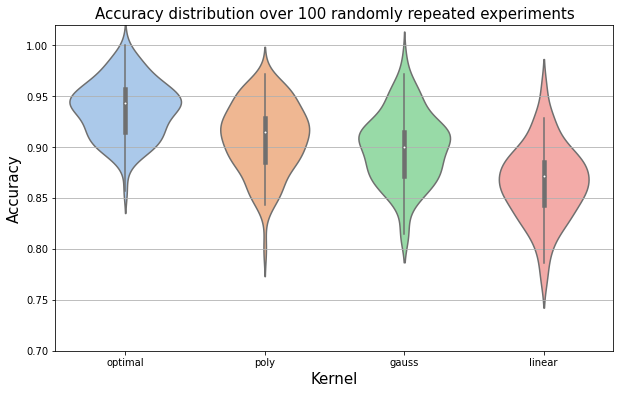

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(10,6))

sns.violinplot(data=acc_df, ax=axes, palette="pastel")

axes.set_title('Accuracy distribution over 100 randomly repeated experiments', fontsize=15)
axes.yaxis.grid(True)
axes.set_xlabel('Kernel', fontsize=15)
axes.set_ylabel('Accuracy', fontsize=15)
axes.set_ylim(bottom=0.7, top=1.02)

plt.show()